In [1]:
def print_full_basins(res):
    total = sum(res["counts_full"].values())
    items = sorted(res["counts_full"].items(), key=lambda kv: -kv[1])  # sort by basin size desc
    print(f"Full attractors (with basin sizes), total sims = {total}")
    for k, count in items:
        prob = res["probs_full"][k]
        lam = len(k)
        states = res.get("decoded_full", {}).get(k, [])
        print(f"  λ={lam}  basin={count}/{total}  (prob={prob:.3f})")
        for s in states:
            print("   ", s)

def print_pseudo_basins(res):
    if not res.get("counts_pseudo"):
        print("No pseudo-attractor basins (pseudo_nodes not set).")
        return
    total = sum(res["counts_pseudo"].values())
    items = sorted(res["counts_pseudo"].items(), key=lambda kv: -kv[1])
    print(f"Pseudo-attractors (with basin sizes), total sims = {total}")
    for k, count in items:
        prob = res["probs_pseudo"][k]
        lam = len(k)     # length of the projected cycle
        states = res.get("decoded_pseudo", {}).get(k, [])
        print(f"  λ={lam}  basin={count}/{total}  (prob={prob:.3f})")
        for s in states:
            print("   ", s)

In [2]:
import sys
sys.path.append("figures_material")
from bnet_viz import render_bnet_graph

art = render_bnet_graph(
    bnet_path="figures_material/networks/revert.bnet",
    base_name="revert_graph_box",
    output_dir="figures_material/figure_6",
    order_mode="osci_order",
    osci_top_pct=0.5,
    osci_seed=7,
    x_gap=2.2, y_gap=1.6,
    max_per_row=6,
    # Node appearance
    use_rounded_box=True,      # ← rounded squares
    node_width=1.4, node_height=0.5, # control box dimensions
    node_border_width=3.0,     # thicker stroke
    fontsize=14,
    fontname="Dejavu Sans",
    bold_labels=True,
    outputs_layout="internal"
)

art


{'dot': 'figures_material\\figure_6\\revert_graph_box.dot',
 'png': 'figures_material\\figure_6\\revert_graph_box.png',
 'svg': 'figures_material\\figure_6\\revert_graph_box.svg',
 'positions_json': 'figures_material\\figure_6\\revert_graph_box_positions.json',
 'neato_found': True,
 'order_mode': 'osci_order',
 'max_per_row_internal': 6,
 'max_per_row_input': None,
 'max_per_row_output': None,
 'focus_targets': None,
 'focus_max_hops': None,
 'outputs_layout': 'internal',
 'num_nodes_drawn': 18,
 'num_edges_drawn': 43}

In [3]:
import sys
sys.path.append("src")
import POKE
import util                   # from src/util.py
from copy import deepcopy

# Load parameters (same as CLI main() would do)
params = util.load_yaml("input/params.yaml")

all controllers        : [['!CDX2', '!MYC', '!SMARCA4']]
relative heights       : [np.int64(1)]
min controllers        : [['!CDX2', '!MYC', '!SMARCA4']]
min robust controllers : [['!CDX2', '!MYC', '!SMARCA4']]
mechanism data         : {'!CDX2 & !MYC & !SMARCA4': {'graph': <networkx.classes.digraph.DiGraph object at 0x000001D08849DB80>, 'controller -> self-driven': [('!CDX2 & !MYC & !SMARCA4', 1)], 'self-driven -> self-driven': [('!CDX2 & !MYC & !SMARCA4', 1)], 'self-driven -> target': [('!CDX2 & !MYC & !SMARCA4', 1)]}}
best controllers       : [['!CDX2', '!MYC', '!SMARCA4']]


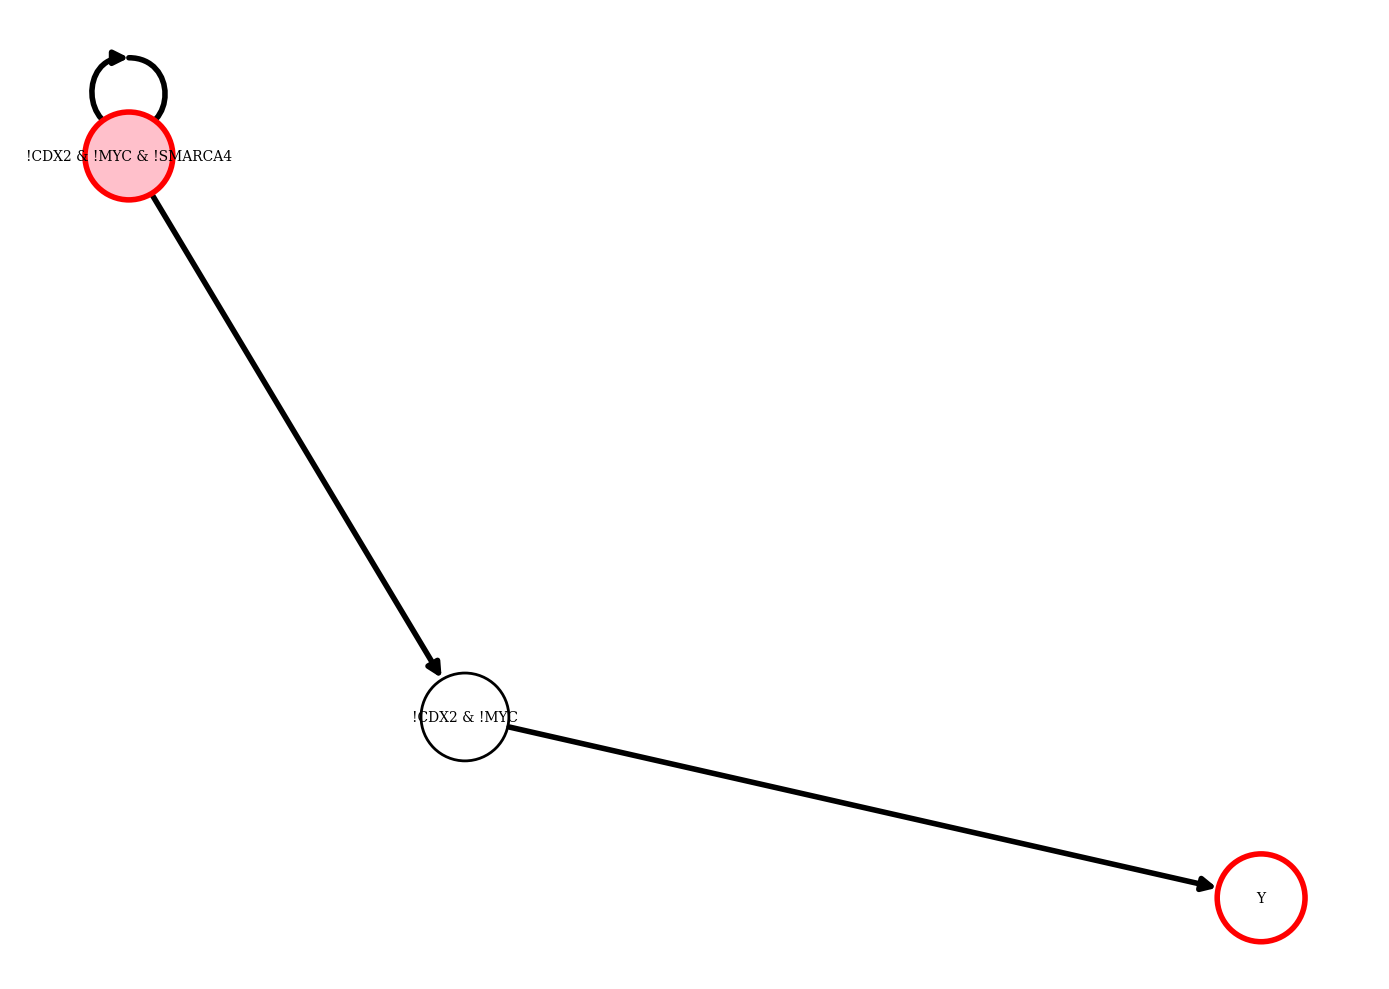

In [4]:
import util, RSC, ensemble, analyze, logic, mechanism

params2 = deepcopy(params)
params2["verbose_poke"] = True
params2["network_file"] = "./figures_material/networks/revert.bnet"  
params2["target"] = "Y"  # e.g. CPC_IPSC
params2["approx"] = False
params2["analysis_order"] = 3
params2["measure_robustness"] = True
params2["find_mechanism"] = True

# 3) Initialize model once
tstart, F, fn, fn_prev = RSC.init(params2)

# 4) Build terminal logic
terminal_logic = ensemble.terminal_logic_predicate(params2, F)

# 5) Run the core analysis (returns a dict)
results = analyze.robustness_and_mechanism(params2, F, terminal_logic)

# 6) Pretty print or use the dict
util.pretty_print(results)

# 4) if you want plots, recompute the aux stuff (cnt_fns, drives, etc.)
controllers = logic.from_pyEda(terminal_logic)
_, self_driven, drives_self_driven, cnt_fns = analyze.calc_driven_and_self_driven(params2, F, controllers)

# 5) choose what to plot: best controllers or a specific one
to_plot = results["best controllers"] or []
if not to_plot and params2.get("controller"):
    # fall back to the single controller in params if it's in the predicate
    try:
        candidate = logic.str_to_F(params2["controller"])[0]
        if candidate in controllers:
            to_plot = [candidate]
    except Exception:
        pass

# 6) make the plots
for ctrl in to_plot:
    mechanism.find_mechanism(
        params2, F, controllers, ctrl, cnt_fns, drives_self_driven, self_driven,
        plot_it=True  # <- ensures plotting
    )

In [5]:
import sys
sys.path.append("src")

from copy import deepcopy
import util
from other_methods import simulate, net
import basin

# 1) Load + merge
params_file = "input/params.yaml"
params_base = util.load_yaml(params_file)

params2 = deepcopy(params_base)
params2["verbose_poke"] = True
params2["network_file"] = "./figures_material/networks/revert.bnet"

sim_params = simulate.get_sim_params(params2)   # adds clause_bin_size, num_samples, time_steps, update_rule, etc.
params = {**sim_params, **params2}              # merged → use THIS everywhere below

# 2) Build/prepare Net with merged params (NOT params2)
G = net.Net(params)
G.prepare(params)

# 3) Define transient control (names must exist in G.nodeNames)
control = {}  # NOTE: double-check names!

# 4) Run basin calc with merged params
res_orig = basin.basin_under_transient_control(
    params, G, control_dict=control,
    max_steps=1000,
    x0_mode="auto",
    seed=42,
    record_stg=False,
    pseudo_nodes=["Y"]      # also double-check names exist
)

# # 5) Inspect
# print("Total simulations:", sum(res["counts_full"].values()))
# print("\nFull attractors (canonical):")
# for k, v in sorted(res["counts_full"].items(), key=lambda kv: -kv[1]):
#     print(f"  size λ={len(k)}  ->  count={v},  prob={res['probs_full'][k]:.3f}")

# print("\nPseudo-attractor basins:")
# if res["counts_pseudo"]:
#     for k, v in sorted(res["counts_pseudo"].items(), key=lambda kv: -kv[1]):
#         print(f"  cycle_len={len(k)}  pattern={k}  ->  count={v},  prob={res['probs_pseudo'][k]:.3f}")
# else:
#     print("  (none requested)")

print_full_basins(res_orig)
print()
print_pseudo_basins(res_orig)

Full attractors (with basin sizes), total sims = 4096
  λ=1  basin=1536/4096  (prob=0.375)
    {'BHLHE40': 1, 'CDX2': 1, 'DDIT3': 1, 'FOSL2': 0, 'FOXO3': 0, 'JUN': 0, 'KLF4': 0, 'KLF5': 0, 'KLF6': 1, 'MAFF': 1, 'MYC': 1, 'NFIA': 1, 'NFIL3': 1, 'RELB': 1, 'SMARCA4': 1, 'SREBF1': 1, 'YY1': 1, 'Y': 0}
  λ=1  basin=780/4096  (prob=0.190)
    {'BHLHE40': 0, 'CDX2': 1, 'DDIT3': 1, 'FOSL2': 0, 'FOXO3': 0, 'JUN': 0, 'KLF4': 0, 'KLF5': 0, 'KLF6': 0, 'MAFF': 0, 'MYC': 1, 'NFIA': 1, 'NFIL3': 1, 'RELB': 1, 'SMARCA4': 1, 'SREBF1': 1, 'YY1': 1, 'Y': 0}
  λ=1  basin=711/4096  (prob=0.174)
    {'BHLHE40': 1, 'CDX2': 1, 'DDIT3': 1, 'FOSL2': 0, 'FOXO3': 0, 'JUN': 0, 'KLF4': 0, 'KLF5': 0, 'KLF6': 0, 'MAFF': 1, 'MYC': 1, 'NFIA': 1, 'NFIL3': 1, 'RELB': 1, 'SMARCA4': 1, 'SREBF1': 1, 'YY1': 1, 'Y': 0}
  λ=1  basin=180/4096  (prob=0.044)
    {'BHLHE40': 1, 'CDX2': 0, 'DDIT3': 1, 'FOSL2': 1, 'FOXO3': 0, 'JUN': 0, 'KLF4': 1, 'KLF5': 0, 'KLF6': 1, 'MAFF': 1, 'MYC': 0, 'NFIA': 0, 'NFIL3': 1, 'RELB': 1, 'SMARCA4':

In [6]:
import sys
sys.path.append("src")

from copy import deepcopy
import util
from other_methods import simulate, net
import basin

# 1) Load + merge
params_file = "input/params.yaml"
params_base = util.load_yaml(params_file)

params2 = deepcopy(params_base)
params2["verbose_poke"] = True
params2["network_file"] = "./figures_material/networks/revert.bnet"

sim_params = simulate.get_sim_params(params2)   # adds clause_bin_size, num_samples, time_steps, update_rule, etc.
params = {**sim_params, **params2}              # merged → use THIS everywhere below

# 2) Build/prepare Net with merged params (NOT params2)
G = net.Net(params)
G.prepare(params)



# 3) Define transient control (names must exist in G.nodeNames)
control = {"CDX2": 0, "SMARCA4": 0, "MYC": 0}  # NOTE: double-check names!

# 4) Run basin calc with merged params
res_orig = basin.basin_under_transient_control(
    params, G, control_dict=control,
    max_steps=1000,
    x0_mode="auto",
    seed=42,
    record_stg=False,     # also double-check names exist
    pseudo_nodes=["Y"]
)



# # 5) Inspect
# print("Total simulations:", sum(res["counts_full"].values()))
# print("\nFull attractors (canonical):")
# for k, v in sorted(res["counts_full"].items(), key=lambda kv: -kv[1]):
#     print(f"  size λ={len(k)}  ->  count={v},  prob={res['probs_full'][k]:.3f}")

# print("\nPseudo-attractor basins:")
# if res["counts_pseudo"]:
#     for k, v in sorted(res["counts_pseudo"].items(), key=lambda kv: -kv[1]):
#         print(f"  cycle_len={len(k)}  pattern={k}  ->  count={v},  prob={res['probs_pseudo'][k]:.3f}")
# else:
#     print("  (none requested)")

print_full_basins(res_orig)
print()
print_pseudo_basins(res_orig)

Full attractors (with basin sizes), total sims = 4096
  λ=1  basin=1461/4096  (prob=0.357)
    {'BHLHE40': 1, 'CDX2': 0, 'DDIT3': 1, 'FOSL2': 1, 'FOXO3': 0, 'JUN': 0, 'KLF4': 1, 'KLF5': 0, 'KLF6': 1, 'MAFF': 1, 'MYC': 0, 'NFIA': 0, 'NFIL3': 1, 'RELB': 1, 'SMARCA4': 0, 'SREBF1': 1, 'YY1': 1, 'Y': 1}
  λ=1  basin=720/4096  (prob=0.176)
    {'BHLHE40': 0, 'CDX2': 0, 'DDIT3': 1, 'FOSL2': 0, 'FOXO3': 0, 'JUN': 0, 'KLF4': 0, 'KLF5': 0, 'KLF6': 0, 'MAFF': 0, 'MYC': 0, 'NFIA': 0, 'NFIL3': 1, 'RELB': 1, 'SMARCA4': 0, 'SREBF1': 1, 'YY1': 1, 'Y': 1}
  λ=1  basin=699/4096  (prob=0.171)
    {'BHLHE40': 1, 'CDX2': 0, 'DDIT3': 1, 'FOSL2': 1, 'FOXO3': 0, 'JUN': 0, 'KLF4': 1, 'KLF5': 0, 'KLF6': 0, 'MAFF': 1, 'MYC': 0, 'NFIA': 0, 'NFIL3': 1, 'RELB': 1, 'SMARCA4': 0, 'SREBF1': 1, 'YY1': 1, 'Y': 1}
  λ=1  basin=199/4096  (prob=0.049)
    {'BHLHE40': 1, 'CDX2': 0, 'DDIT3': 1, 'FOSL2': 1, 'FOXO3': 0, 'JUN': 0, 'KLF4': 1, 'KLF5': 0, 'KLF6': 1, 'MAFF': 1, 'MYC': 0, 'NFIA': 0, 'NFIL3': 1, 'RELB': 0, 'SMARCA4':

In [7]:
control = {"CDX2": 0, "SMARCA4": 0, "MYC": 0}

bias = basin.bias_under_transient_control(
    params, G, control,
    time_steps=1000,
    window=1,         # last 100 steps
    x0_mode="auto",
    max_samples=1000,
    seed=42
)

from pprint import pprint
pprint(bias)


{'BHLHE40': 0.75,
 'CDX2': 0.0,
 'DDIT3': 0.9190000295639038,
 'FOSL2': 0.7929999828338623,
 'FOXO3': 0.029999999329447746,
 'JUN': 0.12200000137090683,
 'KLF4': 0.7590000033378601,
 'KLF5': 0.12200000137090683,
 'KLF6': 0.49900001287460327,
 'MAFF': 0.7590000033378601,
 'MYC': 0.0,
 'NFIA': 0.0,
 'NFIL3': 0.9190000295639038,
 'RELB': 0.8700000047683716,
 'SMARCA4': 0.0,
 'SREBF1': 0.878000020980835,
 'Y': 1.0,
 'YY1': 0.878000020980835}


In [8]:
#From the paper
normal = {'BHLHE40': 0, 'CDX2': 0, 'DDIT3': 1, 'FOSL2': 1, 'FOXO3': 0, 'JUN': 1, 'KLF4': 0, 'KLF5': 1, 'KLF6': 0, 'MAFF': 0, 'MYC': 0, 'NFIA': 0, 'NFIL3': 1, 'RELB': 1, 'SMARCA4': 0, 'SREBF1': 0, 'YY1': 0}
cancer = {'BHLHE40': 0, 'CDX2': 1, 'DDIT3': 0, 'FOSL2': 0, 'FOXO3': 0, 'JUN': 0, 'KLF4': 0, 'KLF5': 0, 'KLF6': 0, 'MAFF': 0, 'MYC': 1, 'NFIA': 1, 'NFIL3': 0, 'RELB': 0, 'SMARCA4': 1, 'SREBF1': 1, 'YY1': 1}

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

fontname = "DejaVu Sans"
fontsize = 12

mpl.rcParams['font.family'] = fontname
mpl.rcParams['font.size'] = fontsize

png_path = "./figures_material/figure_6/bias_heatmap_revert.png"
svg_path = "./figures_material/figure_6/bias_heatmap_revert.svg"

genes = [g for g in bias.keys() if g != "Y"]

data = np.array([
    [cancer[g] for g in genes],
    [bias[g]   for g in genes],
    [normal[g] for g in genes],
], dtype=float)

cmap = LinearSegmentedColormap.from_list(
    "gray_to_active",
    ["#d3d3d3", "#f2be8d"]
)

fig, ax = plt.subplots(figsize=(len(genes) * 0.5 + 2, 4))
im = ax.imshow(data, aspect='auto', cmap=cmap)

ax.set_yticks([0, 1, 2])
ax.set_yticklabels(["Cancer", "Controlled", "Normal"])
ax.set_xticks(np.arange(len(genes)))
ax.set_xticklabels(genes, rotation=90)

plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()

plt.savefig(png_path, dpi=300, bbox_inches="tight")
plt.savefig(svg_path, bbox_inches="tight")
plt.close()

print("Saved PNG:", png_path)
print("Saved SVG:", svg_path)

Saved PNG: ./figures_material/figure_6/bias_heatmap_revert.png
Saved SVG: ./figures_material/figure_6/bias_heatmap_revert.svg


In [10]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# =============================
# 1️⃣ Load data
# =============================
adata_normal = sc.read_10x_h5("figures_material/sc_data/GSM8657092_141N_filtered_feature_bc_matrix.h5")
adata_tumor  = sc.read_10x_h5("figures_material/sc_data/GSM8657093_141T_filtered_feature_bc_matrix.h5")

# Use gene symbols instead of Ensembl IDs if available
if 'gene_names' in adata_normal.var.columns:
    adata_normal.var_names = adata_normal.var['gene_names']
    adata_tumor.var_names  = adata_tumor.var['gene_names']

# Ensure uniqueness
adata_normal.var_names_make_unique()
adata_tumor.var_names_make_unique()

# =============================
# 2️⃣ Concatenate
# =============================
adata = adata_normal.concatenate(
    adata_tumor,
    batch_key='sample',
    batch_categories=['normal', 'tumor'],
    join='outer'  # keep all genes, not just intersecting ones
)

# =============================
# 3️⃣ Preprocessing
# =============================
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=1)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=3000, subset=False)
sc.pp.scale(adata)


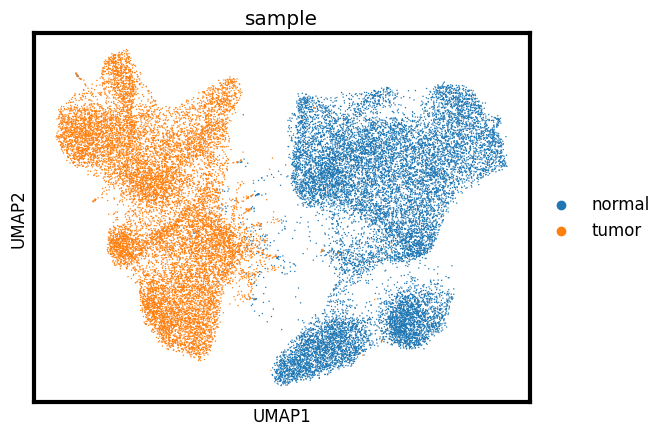

In [11]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='sample')

In [12]:
gene_set_cancer = ['CDX2', 'MYC', 'NFIA', 'SMARCA4', 'SREBF1', 'YY1']
gene_set_normal = ['DDIT3', 'FOSL2', 'JUN', 'KLF5', 'NFIL3', 'RELB']
gene_set_controlled = ['BHLHE40', 'DDIT3', 'FOSL2', 'KLF4', 'KLF6', 'MAFF', 'NFIL3', 'RELB', 'SREBF1', 'YY1']

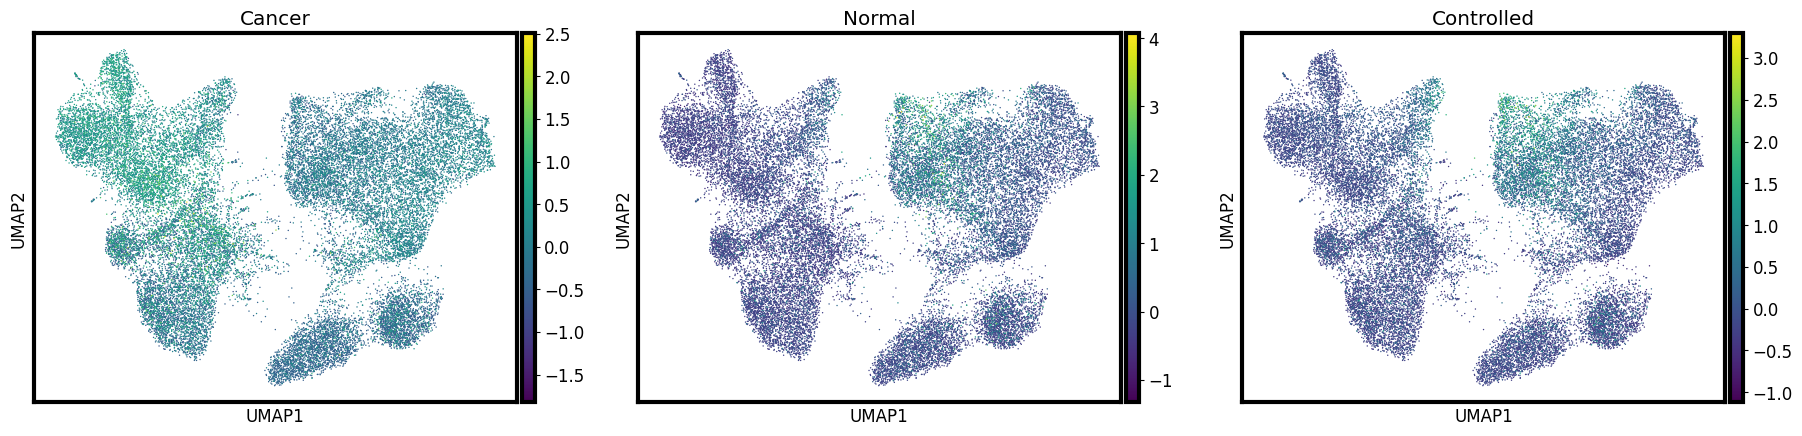

In [13]:
import scanpy as sc
import matplotlib.pyplot as plt

# ============================================================
# 1️⃣ Define gene sets
# ============================================================
gene_sets = {
    "Cancer": gene_set_cancer,
    "Normal": gene_set_normal,
    "Controlled": gene_set_controlled
}

# ============================================================
# 2️⃣ Compute gene set scores (Scanpy does normalization internally)
# ============================================================
for label, genes in gene_sets.items():
    sc.tl.score_genes(adata, gene_list=genes, score_name=f"{label}_score")

# ============================================================
# 3️⃣ Plot the three gene set scores on UMAP side by side
# ============================================================
sc.pl.umap(
    adata, 
    color=[f"{label}_score" for label in gene_sets.keys()],
    cmap="viridis",
    ncols=3,
    frameon=True,
    title=list(gene_sets.keys())
)


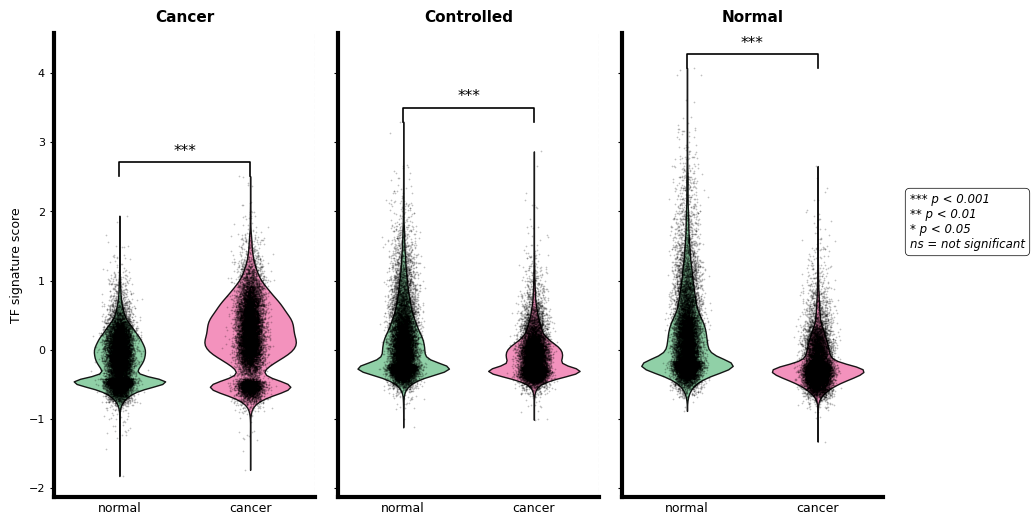

✅ Exported compact version with visible y-ticks and rasterized points.


In [34]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
from pathlib import Path

# Folder to save
output_folder = Path("./figures_material/figure_6")
output_folder.mkdir(parents=True, exist_ok=True)

# Define color scheme
colors = {'normal': '#84cb9e', 'tumor': '#f286b6'}

# Ordered labels
ordered_labels = ['Cancer', 'Controlled', 'Normal']

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(9, 4), sharey=True)

for i, label in enumerate(ordered_labels):
    score_name = f"{label}_score"
    ax = axes[i]

    normal_vals = adata.obs.loc[adata.obs['sample'] == 'normal', score_name]
    tumor_vals  = adata.obs.loc[adata.obs['sample'] == 'tumor',  score_name]

    # violin data
    data = [normal_vals, tumor_vals]
    positions = [0, 1]

    # Plot violins
    parts = ax.violinplot(
        data, positions=positions, widths=0.7, showextrema=False, showmeans=False
    )

    # Recolor violins
    for j, pc in enumerate(parts['bodies']):
        pc.set_facecolor(list(colors.values())[j])
        pc.set_edgecolor('black')
        pc.set_alpha(0.9)

    # Add scatter points
    for j, vals in enumerate(data):
        x = np.random.normal(positions[j], 0.05, size=len(vals))
        ax.scatter(x, vals, s=1.5, alpha=0.25, color='black', linewidth=0)

    # Significance bar
    t_stat, p_val = ttest_ind(normal_vals, tumor_vals, equal_var=False)
    signif = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else 'ns'

    y_max = max(np.max(normal_vals), np.max(tumor_vals))
    ax.plot([0, 0, 1, 1], [y_max, y_max + 0.2, y_max + 0.2, y_max], color='black', lw=1.2)
    ax.text(0.5, y_max + 0.25, signif, ha='center', va='bottom', fontsize=11)

    # Aesthetics
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['normal', 'cancer'], fontsize=9)
    ax.set_title(label, fontsize=11, fontweight='bold', pad=8)

    # Y-axis formatting
    if i == 0:
        ax.set_ylabel('TF signature score', fontsize=9)
        ax.tick_params(axis='y', labelsize=8, length=3, width=0.8, color='black')
    else:
        ax.tick_params(axis='y', which='both', length=3, width=0.8, color='black', labelleft=False)

    # Add vertical dividers only between plots
    if i < len(axes) - 1:
        divider_x = 1.5
        ax.axvline(divider_x, color='gray', linestyle='--', lw=0.8, alpha=0.4)

    ax.spines[['top', 'right']].set_visible(False)
    ax.set_xlim(-0.5, 1.5)
    ax.tick_params(axis='x', length=0)

# Make ticks visible and readable
plt.subplots_adjust(wspace=0.15)
plt.tight_layout()

legend_text = "*** p < 0.001\n** p < 0.01\n* p < 0.05\nns = not significant"

# Place legend slightly outside the right margin
fig.text(
    1.02, 0.85, legend_text,
    ha='left', va='top',
    fontsize=8.5, color='black', style='italic',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4', lw=0.5),
    transform=fig.transFigure  # ensures placement in figure coordinates
)

plt.subplots_adjust(top = 1.25, right=0.99)  # give space on right for legend box


# # Save both versions
# for fmt in ['png', 'svg']:
#     fig.savefig(output_folder / f"figure6_violin_matplotlib_boxlegend.{fmt}",
#                 dpi=300, bbox_inches='tight', format=fmt)

plt.show()
print("✅ Exported compact version with visible y-ticks and rasterized points.")


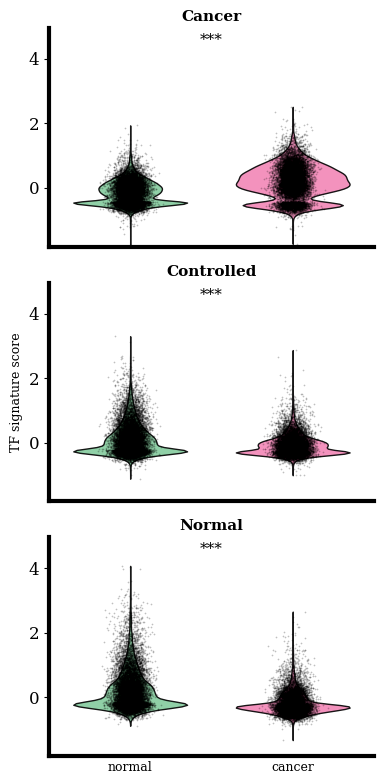

✅ Exported vertical version with consistent y-axis range across all panels.


In [89]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
from pathlib import Path

# Folder to save
output_folder = Path("./figures_material/figure_6")
output_folder.mkdir(parents=True, exist_ok=True)

# Define color scheme
colors = {'normal': '#84cb9e', 'tumor': '#f286b6'}

# Ordered labels (now vertical order)
ordered_labels = ['Cancer', 'Controlled', 'Normal']

# Compute global y-range across all scores
all_scores = []
for label in ordered_labels:
    score_name = f"{label}_score"
    all_scores.extend(adata.obs[score_name])
y_min, y_max = np.min(all_scores), np.max(all_scores)

# Create figure — vertical layout
fig, axes = plt.subplots(3, 1, figsize=(4, 8), sharex=True)

for i, label in enumerate(ordered_labels):
    score_name = f"{label}_score"
    ax = axes[i]

    normal_vals = adata.obs.loc[adata.obs['sample'] == 'normal', score_name]
    tumor_vals  = adata.obs.loc[adata.obs['sample'] == 'tumor',  score_name]

    # Violin data
    data = [normal_vals, tumor_vals]
    positions = [0, 1]

    # Plot violins
    parts = ax.violinplot(
        data, positions=positions, widths=0.7, showextrema=False, showmeans=False
    )

    # Color violins
    for j, pc in enumerate(parts['bodies']):
        pc.set_facecolor(list(colors.values())[j])
        pc.set_edgecolor('black')
        pc.set_alpha(0.9)

    # Scatter points
    for j, vals in enumerate(data):
        x = np.random.normal(positions[j], 0.05, size=len(vals))
        ax.scatter(x, vals, s=1.5, alpha=0.25, color='black', linewidth=0)

    # Significance
    t_stat, p_val = ttest_ind(normal_vals, tumor_vals, equal_var=False)
    signif = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else 'ns'

    ax.text(0.5, y_max + 0.05*(y_max - y_min), signif,
            ha='center', va='bottom', fontsize=11)

    # Labels & aesthetics
    ax.set_title(label, fontsize=11, fontweight='bold', pad=5)
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(y_min, y_max + 0.15*(y_max - y_min))
    ax.spines[['top', 'right']].set_visible(False)
    ax.tick_params(axis='x', length=0)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['normal', 'cancer'], fontsize=9)

    # Y-axis
    if i == 1:
        ax.set_ylabel('TF signature score', fontsize=9)

plt.subplots_adjust(hspace=0.4)
plt.tight_layout()

# Save
for fmt in ['png', 'svg']:
    fig.savefig(output_folder / f"figure6_violin_vertical_consistentY.{fmt}",
                dpi=300, bbox_inches='tight', format=fmt)

plt.show()
print("✅ Exported vertical version with consistent y-axis range across all panels.")


In [38]:
import requests, json, pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def enrichr_query(genes, library="GO_Biological_Process_2023", desc="Gene set"):
    """Query Enrichr for one gene set and library."""
    add_url = "https://maayanlab.cloud/Enrichr/addList"
    enrich_url = "https://maayanlab.cloud/Enrichr/enrich"

    payload = {'list': (None, '\n'.join(genes)), 'description': (None, desc)}
    res = requests.post(add_url, files=payload)
    res.raise_for_status()
    user_list_id = res.json()['userListId']

    query_url = f"{enrich_url}?userListId={user_list_id}&backgroundType={library}"
    enr = requests.get(query_url)
    enr.raise_for_status()
    data = enr.json()

    df = pd.DataFrame(data[library], columns=[
        "Rank", "Term", "P-value", "Odds Ratio", "Combined Score",
        "Overlapping Genes", "Adjusted P-value", "Old P-value", "Old Adjusted P-value"
    ])
    df["Library"] = library
    df["Description"] = desc
    return df


In [74]:
# Your TF gene sets
gene_sets = {
    "Cancer": ['CDX2', 'MYC', 'NFIA', 'SMARCA4', 'SREBF1', 'YY1'],
    "Normal": ['DDIT3', 'FOSL2', 'JUN', 'KLF5', 'NFIL3', 'RELB'],
    "Controlled": ['BHLHE40', 'DDIT3', 'FOSL2', 'KLF4', 'KLF6', 'MAFF', 'NFIL3', 'RELB', 'SREBF1', 'YY1']
}

# Multiple databases
dblist = [
  'KEGG_2021_Human',
  'MSigDB_Hallmark_2020',
  'GO_Biological_Process_2025'
]

# Run enrichment
all_results = []
for label, genes in gene_sets.items():
    for db in dblist:
        print(f"Running {label} → {db}")
        df = enrichr_query(genes, db, desc=label)
        all_results.append(df)

df_all = pd.concat(all_results, ignore_index=True)
df_all.to_csv("enrichment_results.csv", index=False)
print("✅ Enrichment completed and saved to enrichment_results.csv")


Running Cancer → KEGG_2021_Human
Running Cancer → MSigDB_Hallmark_2020
Running Cancer → GO_Biological_Process_2025
Running Normal → KEGG_2021_Human
Running Normal → MSigDB_Hallmark_2020
Running Normal → GO_Biological_Process_2025
Running Controlled → KEGG_2021_Human
Running Controlled → MSigDB_Hallmark_2020
Running Controlled → GO_Biological_Process_2025
✅ Enrichment completed and saved to enrichment_results.csv


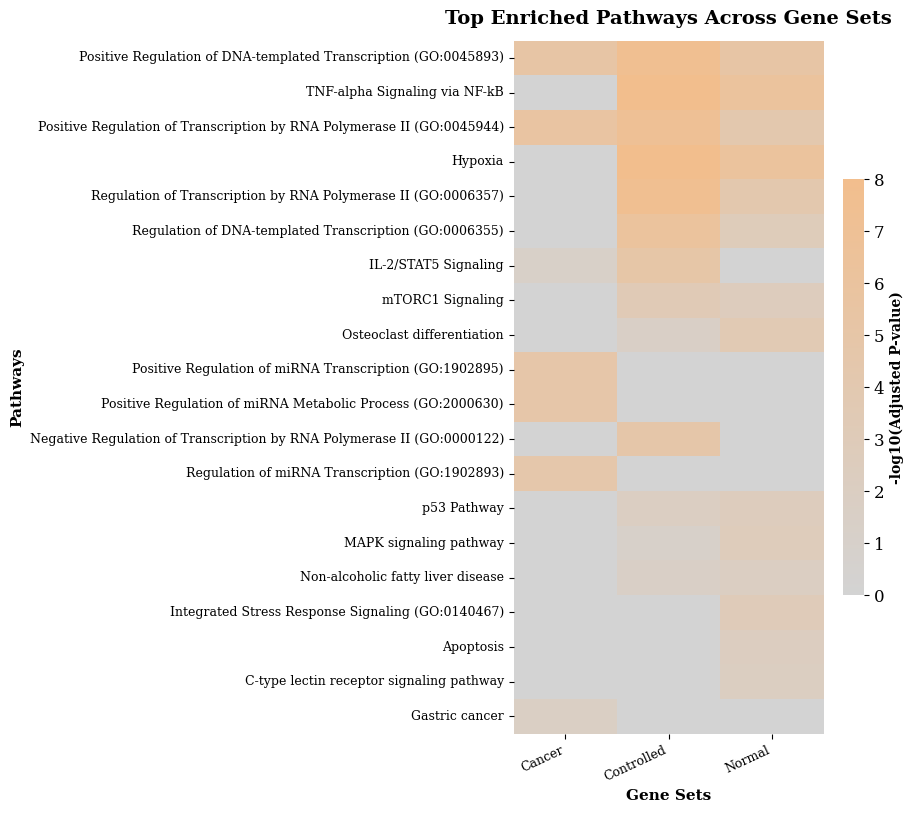

✅ Saved refined heatmap with balanced tick vs label weight (gray→peach).


In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
from pathlib import Path

# Font setup
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Noto Serif', 'DejaVu Serif', 'Times New Roman']

# Custom color map: gray → peach
cmap = LinearSegmentedColormap.from_list("gray_peach", ["#d3d3d3", "#f2be8d"])

# Select top N pathways
N = 20
top_terms = (
    pivot_df.mean(axis=1)
    .sort_values(ascending=False)
    .head(N)
    .index
)
pivot_df_top = pivot_df.loc[top_terms]

# Figure size
fig_height = max(6, N * 0.45)
fig_width = max(5, pivot_df_top.shape[1] * 0.4)

fig, ax = plt.subplots(figsize=(fig_width, fig_height))
sns.heatmap(
    pivot_df_top,
    cmap=cmap,
    linewidths=0,
    linecolor=None,
    cbar_kws={"label": "-log10(Adjusted P-value)", "shrink": 0.6},
    vmin=0, vmax=8,
    ax=ax
)

# Labels and title
plt.title(f"Top Enriched Pathways Across Gene Sets",
          fontsize=14, fontweight='bold', pad=12)
plt.xlabel("Gene Sets", fontsize=11, fontweight='semibold')
plt.ylabel("Pathways", fontsize=11, fontweight='semibold')

# Tick label style: medium weight
for tick_label in ax.get_xticklabels():
    tick_label.set_fontweight('medium')
for tick_label in ax.get_yticklabels():
    tick_label.set_fontweight('medium')

plt.xticks(rotation=25, ha='right', fontsize=9)
plt.yticks(fontsize=9)
sns.despine(left=True, bottom=True)
ax.tick_params(bottom=True, left=True)

# Colorbar styling
cbar = ax.collections[0].colorbar
cbar.set_label("-log10(Adjusted P-value)", fontsize=10, fontweight='semibold')

# Save high quality
output_folder = Path("./figures_material/figure_6")
output_folder.mkdir(parents=True, exist_ok=True)
plt.savefig(output_folder / "enrichment_heatmap_balanced.png",
            dpi=600, bbox_inches='tight', pad_inches=0.05)
plt.savefig(output_folder / "enrichment_heatmap_balanced.svg",
            format='svg', bbox_inches='tight', pad_inches=0.05)

plt.show()
print("✅ Saved refined heatmap with balanced tick vs label weight (gray→peach).")


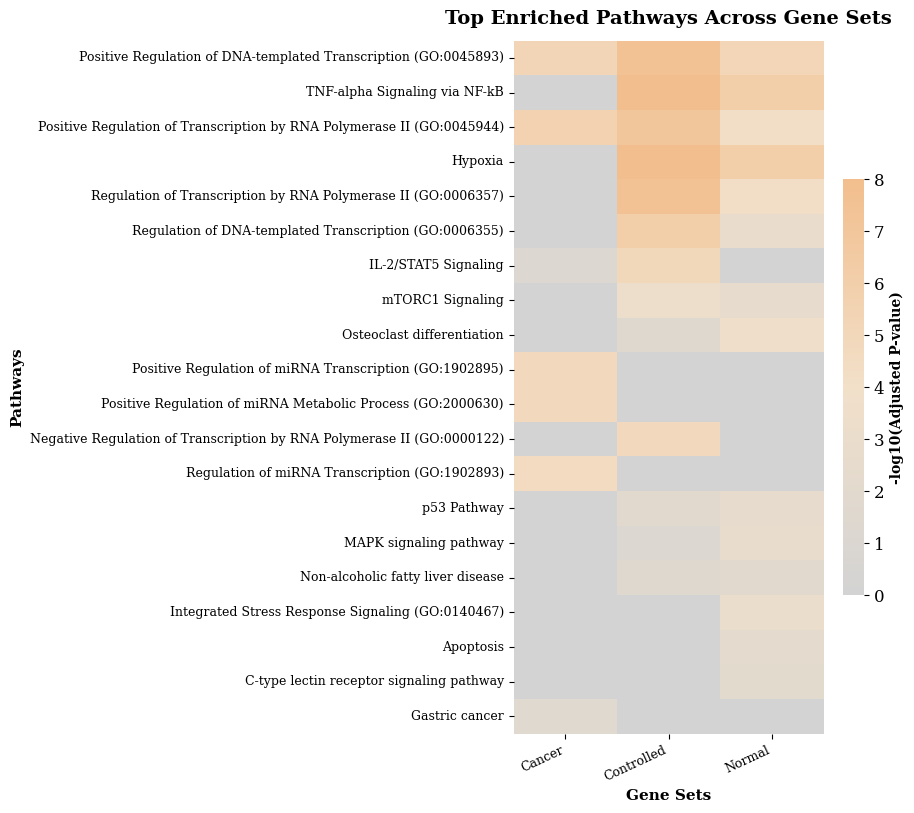

✅ Saved 3-color heatmap (gray → beige → peach, better midrange contrast).


In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
from pathlib import Path

# Font setup
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Noto Serif', 'DejaVu Serif', 'Times New Roman']

# Three-color map: gray → light beige → peach
cmap = LinearSegmentedColormap.from_list(
    "gray_beige_peach",
    ["#d3d3d3", "#f2e0c9", "#f2be8d"]
)

# Select top N pathways
N = 20
top_terms = (
    pivot_df.mean(axis=1)
    .sort_values(ascending=False)
    .head(N)
    .index
)
pivot_df_top = pivot_df.loc[top_terms]

# Figure size
fig_height = max(6, N * 0.45)
fig_width = max(5, pivot_df_top.shape[1] * 0.4)

fig, ax = plt.subplots(figsize=(fig_width, fig_height))
sns.heatmap(
    pivot_df_top,
    cmap=cmap,
    linewidths=0,
    cbar_kws={"label": "-log10(Adjusted P-value)", "shrink": 0.6},
    vmin=0, vmax=8,
    ax=ax
)

# Labels and title
plt.title("Top Enriched Pathways Across Gene Sets",
          fontsize=14, fontweight='bold', pad=12)
plt.xlabel("Gene Sets", fontsize=11, fontweight='semibold')
plt.ylabel("Pathways", fontsize=11, fontweight='semibold')

# Tick label style
for tick_label in ax.get_xticklabels():
    tick_label.set_fontweight('medium')
for tick_label in ax.get_yticklabels():
    tick_label.set_fontweight('medium')

plt.xticks(rotation=25, ha='right', fontsize=9)
plt.yticks(fontsize=9)
sns.despine(left=True, bottom=True)
ax.tick_params(bottom=True, left=True)

# Colorbar styling
cbar = ax.collections[0].colorbar
cbar.set_label("-log10(Adjusted P-value)", fontsize=10, fontweight='semibold')

# Save high quality
output_folder = Path("./figures_material/figure_6")
output_folder.mkdir(parents=True, exist_ok=True)
plt.savefig(output_folder / "enrichment_heatmap_threecolor.png",
            dpi=600, bbox_inches='tight', pad_inches=0.05)
plt.savefig(output_folder / "enrichment_heatmap_threecolor.svg",
            format='svg', bbox_inches='tight', pad_inches=0.05)

plt.show()
print("✅ Saved 3-color heatmap (gray → beige → peach, better midrange contrast).")


In [100]:
# Your TF gene sets
gene_sets = {
    "Cancer": ['CDX2', 'MYC', 'NFIA', 'SMARCA4', 'SREBF1', 'YY1'],
    "Normal": ['DDIT3', 'FOSL2', 'JUN', 'KLF5', 'NFIL3', 'RELB'],
    "Controlled": ['BHLHE40', 'DDIT3', 'FOSL2', 'KLF4', 'KLF6', 'MAFF', 'NFIL3', 'RELB', 'SREBF1', 'YY1']
}

# Multiple databases
dblist = [
  'KEGG_2021_Human',
  'MSigDB_Hallmark_2020',
  'GO_Biological_Process_2025',
  'MSigDB_Oncogenic_Signatures'
]

# Run enrichment
all_results = []
for label, genes in gene_sets.items():
    for db in dblist:
        print(f"Running {label} → {db}")
        df = enrichr_query(genes, db, desc=label)
        all_results.append(df)

df_all = pd.concat(all_results, ignore_index=True)
df_all.to_csv("enrichment_results.csv", index=False)
print("✅ Enrichment completed and saved to enrichment_results.csv")


Running Cancer → KEGG_2021_Human
Running Cancer → MSigDB_Hallmark_2020
Running Cancer → GO_Biological_Process_2025
Running Cancer → MSigDB_Oncogenic_Signatures
Running Normal → KEGG_2021_Human
Running Normal → MSigDB_Hallmark_2020
Running Normal → GO_Biological_Process_2025
Running Normal → MSigDB_Oncogenic_Signatures
Running Controlled → KEGG_2021_Human
Running Controlled → MSigDB_Hallmark_2020
Running Controlled → GO_Biological_Process_2025
Running Controlled → MSigDB_Oncogenic_Signatures
✅ Enrichment completed and saved to enrichment_results.csv


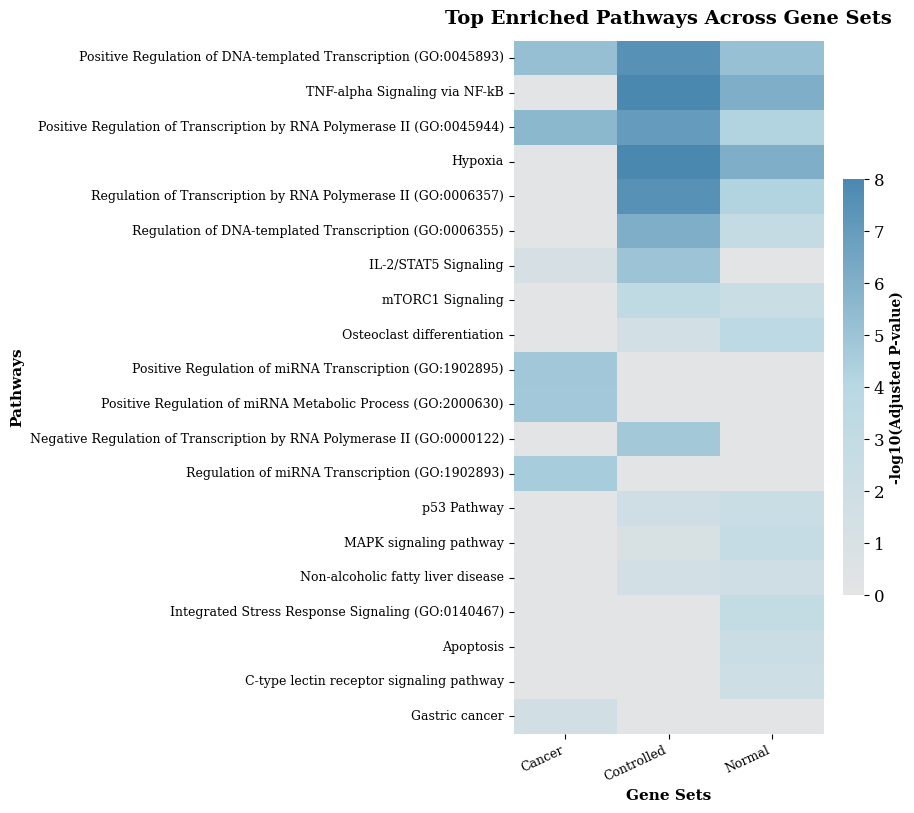

✅ Saved 3-color heatmap (gray → beige → peach, better midrange contrast).


In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
from pathlib import Path

# Font setup
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Noto Serif', 'DejaVu Serif', 'Times New Roman']

# Three-color map: gray → light beige → peach
cmap = LinearSegmentedColormap.from_list(
    "gray_aqua_blue",
    ["#e3e4e5", "#b8d8e3", "#4b88b0"]  # light gray → aqua → medium blue
)

# Select top N pathways
N = 20
top_terms = (
    pivot_df.mean(axis=1)
    .sort_values(ascending=False)
    .head(N)
    .index
)
pivot_df_top = pivot_df.loc[top_terms]

# Figure size
fig_height = max(6, N * 0.45)
fig_width = max(5, pivot_df_top.shape[1] * 0.4)

fig, ax = plt.subplots(figsize=(fig_width, fig_height))
sns.heatmap(
    pivot_df_top,
    cmap=cmap,
    linewidths=0,
    cbar_kws={"label": "-log10(Adjusted P-value)", "shrink": 0.6},
    vmin=0, vmax=8,
    ax=ax
)

# Labels and title
plt.title("Top Enriched Pathways Across Gene Sets",
          fontsize=14, fontweight='bold', pad=12)
plt.xlabel("Gene Sets", fontsize=11, fontweight='semibold')
plt.ylabel("Pathways", fontsize=11, fontweight='semibold')

# Tick label style
for tick_label in ax.get_xticklabels():
    tick_label.set_fontweight('medium')
for tick_label in ax.get_yticklabels():
    tick_label.set_fontweight('medium')

plt.xticks(rotation=25, ha='right', fontsize=9)
plt.yticks(fontsize=9)
sns.despine(left=True, bottom=True)
ax.tick_params(bottom=True, left=True)

# Colorbar styling
cbar = ax.collections[0].colorbar
cbar.set_label("-log10(Adjusted P-value)", fontsize=10, fontweight='semibold')

# Save high quality
output_folder = Path("./figures_material/figure_6")
output_folder.mkdir(parents=True, exist_ok=True)
plt.savefig(output_folder / "enrichment_heatmap_threecolor.png",
            dpi=600, bbox_inches='tight', pad_inches=0.05)
plt.savefig(output_folder / "enrichment_heatmap_threecolor.svg",
            format='svg', bbox_inches='tight', pad_inches=0.05)

plt.show()
print("✅ Saved 3-color heatmap (gray → beige → peach, better midrange contrast).")


In [97]:
import requests
import pandas as pd

url = "https://maayanlab.cloud/Enrichr/datasetStatistics"
resp = requests.get(url)
resp.raise_for_status()
libs_info = resp.json()['statistics']
df_libs = pd.DataFrame(libs_info)
print(df_libs['libraryName'].head(50))


0                                   Genome_Browser_PWMs
1                              TRANSFAC_and_JASPAR_PWMs
2                             Transcription_Factor_PPIs
3                                             ChEA_2013
4                      Drug_Perturbations_from_GEO_2014
5                               ENCODE_TF_ChIP-seq_2014
6                                         BioCarta_2013
7                                     WikiPathways_2013
8                   Disease_Signatures_from_GEO_up_2014
9                                             KEGG_2013
10                           TF-LOF_Expression_from_GEO
11                                  TargetScan_microRNA
12                                     PPI_Hub_Proteins
13                                            GeneSigDB
14                                  Chromosome_Location
15                                     Human_Gene_Atlas
16                                     Mouse_Gene_Atlas
17                             Human_Phenotype_O